# Creating dataset

# Creating classification model

In [1]:
import os
import pickle
import numpy as np
import os
# import cv2
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import keras
import shutil

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

Using TensorFlow backend.


In [2]:
DATASET_PATH = '../../datasets/Classification/Dataset - 7 dias'
CATEGORIES = ["Normal", "Anormal", "Morta"]

##### Read dataset

In [3]:
IMG_SIZE = 256

def read_dataset():
    images_raw = open(os.path.join(DATASET_PATH, "7_days_images.pickle" ), "rb")
    images = pickle.load(images_raw)

    labels_raw = open(os.path.join(DATASET_PATH, "7_days_labels.pickle" ), "rb")
    labels = pickle.load(labels_raw)

    images = np.array(images)
    labels = np.array(labels)
    
    return images, labels

###### Turn it into a binary classification problem

In [4]:
def to_binary(labels):
    labels[labels == 2] = 1
    return labels
    

###### Train Test split

In [5]:
def count_samples(train_labels, test_labels):
    print("In training:")
    for i in range(0,NUM_CLASSES):
        print(f'Class {i}: {round(100 * np.count_nonzero(np.array(train_labels) == i) / len(train_labels), 2)}%')
    print("In test:")
    for i in range(0,NUM_CLASSES):
        print(f'Class {i}: {round(100 * np.count_nonzero(np.array(test_labels) == i) / len(test_labels), 2)}%')


def train_test_split(images, labels):

    from sklearn.model_selection import train_test_split

    train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.1, stratify=labels)
    
    print("In training:")
    for i in range(0,len(np.unique(labels))):
        print(f'Class {i}: {round(100 * np.count_nonzero(np.array(train_labels) == i) / len(train_labels), 2)}%')
    print("In test:")
    for i in range(0,len(np.unique(labels))):
        print(f'Class {i}: {round(100 * np.count_nonzero(np.array(test_labels) == i) / len(test_labels), 2)}%')
        
    return train_images, test_images, train_labels, test_labels

#### Ajustando o dataset desbalanceado

###### Data augmentation -> data generator

In [6]:
# data augmentation with ImageDataGenerator -> did not go well
# from keras.preprocessing.image import ImageDataGenerator
# datagen = ImageDataGenerator(
#     featurewise_center=True,
#     featurewise_std_normalization=False,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True,
#     validation_split=0.25
# )
# datagen.fit(train_images)

# # it = datagen.flow(train_images, batch_size=1, save_to_dir="test", shuffle= True)

# # # generate samples and plot
# # for i in range(50):
# #      # generate batch of images
# #     batch = it.next()
# #     # convert to unsigned integers for viewing
# #     image = batch[0].astype('uint8')
# #     # plot raw pixel data
# #     plt.imshow(image, cmap="gray")
# #     plt.show()
# # show the figure

###### Weighted Classes 

In [7]:
# Trying class weights
# it does not work with one hot encoded data
# from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight('balanced',
#                                                  np.unique(train_labels),
#                                                  train_labels)

def get_sample_weights(train_labels):
    from sklearn.utils import compute_sample_weight
    
    return compute_sample_weight('balanced', train_labels)  #->>>> remember to add the weights in model.fit

###### SMOTE

In [8]:
# classes, counts = np.unique(train_labels, return_counts=True)
# print(f"The number of elements for each class in training now are\nClass 0: {counts[0]}\nClass 1 {counts[1]}\nClass 2 {counts[2]}\n")

In [9]:
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state=42)

# train_images_shape = train_images.shape
# train_images = train_images.reshape((train_images_shape[0], IMG_SIZE * IMG_SIZE * 3))
# train_images, train_labels = sm.fit_resample(train_images, train_labels)


In [10]:
# train_images_shape = train_images.shape
# train_images = train_images.reshape((train_images_shape[0], IMG_SIZE, IMG_SIZE, 3))


In [11]:
# classes, counts = np.unique(train_labels, return_counts=True)
# print(f"The number of elements for each class in training now are\nClass 0: {counts[0]}\nClass 1 {counts[1]}\nClass 2 {counts[2]}\n")

##### One hot label encoding

In [12]:
def to_one_hot(data):
    import pandas as pd
    data = pd.get_dummies(data)
    data = pd.DataFrame.to_numpy(data)
    return data

##### Normalizing training images

In [13]:
def normalize_images(data):
    data = tf.keras.utils.normalize(data, axis=0, order=2)
    return data

### Creating the model


In [14]:
EPOCHS = None
TRAIN_TEST_SPLIT = None
BATCH_SIZE = None
# print((1 - TRAIN_TEST_SPLIT) * train_images.shape[0],BATCH_SIZE)

METRICDIR = '../metricas/classificacao/7_d/tests-binary'

MODELDIR = os.path.join(METRICDIR, "transfer")

CHECKPOINT_DIR = os.path.join(MODELDIR, "models") 

if os.path.exists(MODELDIR):
    shutil.rmtree(MODELDIR)
    os.makedirs(CHECKPOINT_DIR)
    
my_metrics = ["accuracy",
       tf.keras.metrics.Precision(),
       tf.keras.metrics.Recall(),
       tf.keras.metrics.AUC(),
       tf.keras.metrics.TruePositives(),
       tf.keras.metrics.TrueNegatives(),
       tf.keras.metrics.FalsePositives(),
       tf.keras.metrics.FalseNegatives(),]

In [15]:
def create_model():
       
    base_model = keras.applications.Xception(
        weights='imagenet',  # Load weights pre-trained on ImageNet.
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(IMG_SIZE,IMG_SIZE, 3))
    # We make sure that the base_model is running in inference mode here,
    # by passing `training=False`. This is important for fine-tuning, as you will
    # learn in a few paragraphs.
    x = base_model(inputs)
    # Convert features of shape `base_model.output_shape[1:]` to vectors
    x = keras.layers.Flatten()(x)
    # A Dense classifier 
    outputs = keras.layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs)

    opt = keras.optimizers.Adam()

    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=my_metrics)
    
    return model

def get_model_name(k):
    return 'model_'+str(k)

def plot_metric(history,metric_name, chart_name, save_dir, save = False, show = False):
    plt.cla() 
    plt.plot(history.history[metric_name], label = metric_name + ' (training data)')
    plt.plot(history.history[metric_name], label = metric_name + ' (validation data)')
    plt.title(chart_name)
    plt.ylabel( metric_name + ' value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    if save:
        plt.savefig(os.path.join(save_dir, metric_name))
    if show:
        plt.show()
        
        
def plot_cm(cf_matrix, save_dir, save):
    
    import seaborn as sns; sns.set_theme()
   
    group_names = ['True Pos','False Pos','False Neg','True Neg']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    plt.cla() 
    
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    if save:
        plt.savefig(os.path.join(save_dir, "confusion matrix"))
    plt.show()

##### Testing the model

In [16]:
def one_hot_to_1d(test_labels):
    
    test_labels_1d = []
    
    for label in test_labels:
        print()
        if (label == [1, 0]).all():
            test_labels_1d.append(0)
        elif (label == [0, 1]).all():
            test_labels_1d.append(1)
        else:
            test_labels_1d.append(2)
    
    return test_labels_1d
    
def get_predictions(model,test_images, test_labels):
    prediction = model.predict(test_images, batch_size=1)

    return tf.argmax(prediction, axis=-1)

def get_confusion_matrix(test_labels, prediction):
    
    test_labels_1d = one_hot_to_1d(test_labels)
    
    cm = metrics.confusion_matrix(test_labels_1d, prediction)
    cm = make_confusion_matrix(cm, figsize=(8,6), cbar=False)
    
    return cm

In [17]:
def train_models(train_images, train_labels, num_folds=10):
    
    from sklearn.model_selection import StratifiedKFold
    
    kfold = StratifiedKFold(n_splits=num_folds)

    #metrics containers
    acc = []
    prec = []
    rec = []
    auc = []

    # K-fold Cross Validation model evaluation
    fold_no = 1
    for train, test in kfold.split(train_images, train_labels):

#         from tf.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

        if fold_no - 1 == 0:
            idx_str = ""
        else:
            idx_str = f"_{fold_no}"
            
        fold_checkpoint_dir = os.path.join(CHECKPOINT_DIR, get_model_name(fold_no))
        
        if not os.path.exists(fold_checkpoint_dir):
            os.makedirs(fold_checkpoint_dir)
        
#         my_callbacks = [
# #             ModelCheckpoint(os.path.join(fold_checkpoint_dir,"model.h5"), monitor=f"val_precision", verbose=1, save_best_only=True, mode='max', save_freq='epoch'),
#             ReduceLROnPlateau(monitor=f'loss', factor=0.7, patience=2, min_lr=0.00000000001, mode='min'),
#         ]

        model = create_model()

        # Generate a print
        print('------------------------------------------------------------------------', end="\n\n")
        print(f'Training for fold {fold_no} ...')

#         # Fit data to model
#         history = model.fit(
#             train_images[train],
#             train_labels[train],
#             batch_size = BATCH_SIZE,
#             epochs = EPOCHS,
#             validation_split=TRAIN_TEST_SPLIT,
#             sample_weight=get_sample_weights(train_labels[train]),
#             callbacks=[my_callbacks])
        # Fit data to model
        
        history = model.fit(
            train_images[train],
            train_labels[train],
            batch_size = BATCH_SIZE,
            epochs = EPOCHS,
            validation_split=TRAIN_TEST_SPLIT,
            sample_weight=get_sample_weights(train_labels[train]))
        
        prediction = model.predict(train_images[test], batch_size=1)
        
        thresh = np.mean(prediction)
        
        prediction[prediction > thresh] = 1
        prediction[prediction <= thresh] = 0
        
        cm = metrics.confusion_matrix(train_labels[test], prediction)
        
        plot_cm(cm, save_dir=fold_checkpoint_dir, save=True)
        
        #visualizing training
        NUM_METRICS = len(my_metrics) + 1
        for metric in list(history.history.keys())[:NUM_METRICS]:
            plot_metric(history, metric, metric + " for soybean classification", save_dir=fold_checkpoint_dir, save=True)

        # Generate generalization metrics
        scores = model.evaluate(images[test], labels[test], verbose=0)
        print(f'Scores for fold {fold_no}:')
        for i in range(len(my_metrics)):   
            print(f'{model.metrics_names[i]} of {scores[i]}')

        acc.append(scores[1])
        prec.append(scores[2])
        rec.append(scores[3])
        auc.append(scores[4])

        # Increase fold number
        fold_no = fold_no + 1
        
    return acc, prec, rec, auc

##### Training

In [18]:
images, labels = read_dataset()
labels = to_binary(labels)

------------------------------------------------------------------------

Training for fold 1 ...
Train on 798 samples, validate on 267 samples
Epoch 1/10
798/798 [==============================] - 15s 19ms/step - loss: 0.7009 - accuracy: 0.8446 - precision: 0.4722 - recall: 0.7053 - auc: 0.7972 - true_positives: 71.5200 - true_negatives: 258.8600 - false_positives: 59.6200 - false_negatives: 17.9600 - val_loss: 67.2919 - val_accuracy: 0.8052 - val_precision: 0.5992 - val_recall: 0.7188 - val_auc: 0.8287 - val_true_positives: 145.0000 - val_true_negatives: 641.8823 - val_false_positives: 97.0000 - val_false_negatives: 57.8235
Epoch 2/10
798/798 [==============================] - 8s 10ms/step - loss: 0.3696 - accuracy: 0.9236 - precision: 0.6442 - recall: 0.7276 - auc: 0.8391 - true_positives: 228.6800 - true_negatives: 1036.6200 - false_positives: 124.4600 - false_negatives: 83.2000 - val_loss: 106.7277 - val_accuracy: 0.8015 - val_precision: 0.6750 - val_recall: 0.7178 - val_auc: 0.83

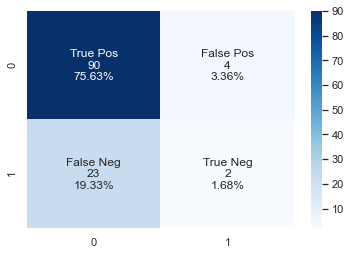

Scores for fold 1:
loss of 58.978234828019346
accuracy of 0.7731092572212219
precision of 0.7842657566070557
recall of 0.7455199956893921
auc of 0.8578112125396729
true_positives of 1682.25
true_negatives of 8008.5
false_positives of 462.75
------------------------------------------------------------------------

Training for fold 2 ...
Train on 798 samples, validate on 267 samples
Epoch 1/10
798/798 [==============================] - 11s 14ms/step - loss: 0.8110 - accuracy: 0.8095 - precision: 0.7682 - recall: 0.7462 - auc: 0.8582 - true_positives: 1757.3000 - true_negatives: 8291.0400 - false_positives: 530.9000 - false_negatives: 597.7200 - val_loss: 60.3526 - val_accuracy: 0.5094 - val_precision: 0.7445 - val_recall: 0.7424 - val_auc: 0.8536 - val_true_positives: 1832.0588 - val_true_negatives: 8613.7061 - val_false_positives: 629.1765 - val_false_negatives: 635.7647
Epoch 2/10
798/798 [==============================] - 8s 11ms/step - loss: 0.2207 - accuracy: 0.9536 - precision: 0.

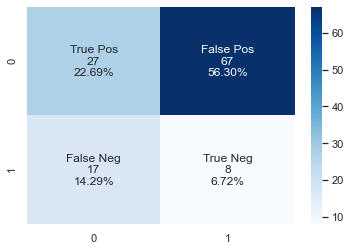

Scores for fold 2:
loss of 59.287324120016656
accuracy of 0.29411765933036804
precision of 0.691443145275116
recall of 0.7555553913116455
auc of 0.845077633857727
true_positives of 3417.75
true_negatives of 15448.0
false_positives of 1525.25
------------------------------------------------------------------------

Training for fold 3 ...
Train on 798 samples, validate on 267 samples
Epoch 1/10
798/798 [==============================] - 10s 13ms/step - loss: 0.8716 - accuracy: 0.8333 - precision: 0.6843 - recall: 0.7562 - auc: 0.8446 - true_positives: 3493.5801 - true_negatives: 15714.4004 - false_positives: 1612.0000 - false_negatives: 1125.9800 - val_loss: 115.7516 - val_accuracy: 0.7640 - val_precision: 0.6820 - val_recall: 0.7549 - val_auc: 0.8436 - val_true_positives: 3572.5881 - val_true_negatives: 16080.7646 - val_false_positives: 1666.1177 - val_false_negatives: 1160.2354
Epoch 2/10
798/798 [==============================] - 8s 10ms/step - loss: 0.3168 - accuracy: 0.9148 - preci

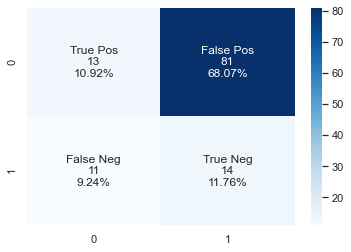

Scores for fold 3:
loss of 52.005775387547594
accuracy of 0.22689075767993927
precision of 0.6784631013870239
recall of 0.7641277313232422
auc of 0.8462967872619629
true_positives of 5189.0
true_negatives of 23015.75
false_positives of 2459.25
------------------------------------------------------------------------

Training for fold 4 ...
Train on 798 samples, validate on 267 samples
Epoch 1/10
798/798 [==============================] - 11s 13ms/step - loss: 0.7247 - accuracy: 0.8371 - precision: 0.6728 - recall: 0.7642 - auc: 0.8462 - true_positives: 5259.7998 - true_negatives: 23274.1191 - false_positives: 2558.3201 - false_negatives: 1622.7200 - val_loss: 110.4861 - val_accuracy: 0.7790 - val_precision: 0.6728 - val_recall: 0.7624 - val_auc: 0.8452 - val_true_positives: 5335.0000 - val_true_negatives: 23655.9414 - val_false_positives: 2594.9412 - val_false_negatives: 1662.8235
Epoch 2/10
798/798 [==============================] - 9s 11ms/step - loss: 0.3111 - accuracy: 0.9223 - pre

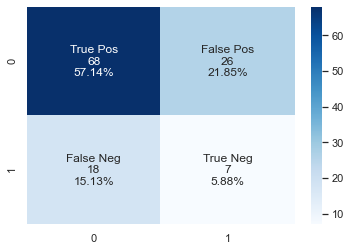

Scores for fold 4:
loss of 25.81571153031678
accuracy of 0.6302521228790283
precision of 0.6894188523292542
recall of 0.7618745565414429
auc of 0.8476559519767761
true_positives of 6901.25
true_negatives of 30867.5
false_positives of 3109.0
------------------------------------------------------------------------

Training for fold 5 ...
Train on 799 samples, validate on 267 samples
Epoch 1/10
799/799 [==============================] - 12s 16ms/step - loss: 0.6901 - accuracy: 0.8335 - precision: 0.6870 - recall: 0.7622 - auc: 0.8480 - true_positives: 6972.1802 - true_negatives: 31159.1602 - false_positives: 3177.2600 - false_negatives: 2175.3799 - val_loss: 142.4461 - val_accuracy: 0.7903 - val_precision: 0.6860 - val_recall: 0.7608 - val_auc: 0.8475 - val_true_positives: 7047.4116 - val_true_negatives: 31530.0000 - val_false_positives: 3225.8823 - val_false_negatives: 2215.4119
Epoch 2/10
799/799 [==============================] - 9s 11ms/step - loss: 0.2864 - accuracy: 0.9387 - precis

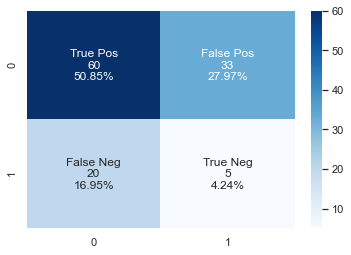

Scores for fold 5:
loss of 47.2909693475497
accuracy of 0.5508474707603455
precision of 0.6691919565200806
recall of 0.766596794128418
auc of 0.8460063934326172
true_positives of 8680.75
true_negatives of 38198.5
false_positives of 4291.25
------------------------------------------------------------------------

Training for fold 6 ...
Train on 799 samples, validate on 267 samples
Epoch 1/10
799/799 [==============================] - 11s 14ms/step - loss: 1.3342 - accuracy: 0.8173 - precision: 0.6668 - recall: 0.7664 - auc: 0.8458 - true_positives: 8748.2998 - true_negatives: 38475.5195 - false_positives: 4372.2998 - false_negatives: 2665.8601 - val_loss: 19.7359 - val_accuracy: 0.4981 - val_precision: 0.6639 - val_recall: 0.7665 - val_auc: 0.8455 - val_true_positives: 8836.4707 - val_true_negatives: 38794.8828 - val_false_positives: 4474.0000 - val_false_negatives: 2691.3530
Epoch 2/10
799/799 [==============================] - 8s 11ms/step - loss: 0.5798 - accuracy: 0.9124 - precisio

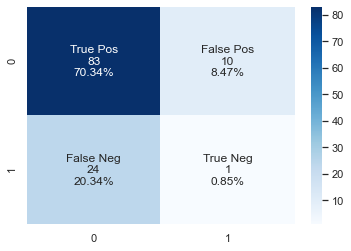

Scores for fold 6:
loss of 84.26444791787762
accuracy of 0.7457627058029175
precision of 0.6762093901634216
recall of 0.7661300897598267
auc of 0.847590446472168
true_positives of 10410.75
true_negatives of 46017.75
false_positives of 4985.0
------------------------------------------------------------------------

Training for fold 7 ...
Train on 799 samples, validate on 267 samples
Epoch 1/10
799/799 [==============================] - 11s 13ms/step - loss: 0.7562 - accuracy: 0.8398 - precision: 0.6750 - recall: 0.7665 - auc: 0.8478 - true_positives: 10480.9600 - true_negatives: 46318.4805 - false_positives: 5047.0400 - false_negatives: 3193.5000 - val_loss: 113.4874 - val_accuracy: 0.7865 - val_precision: 0.6747 - val_recall: 0.7653 - val_auc: 0.8474 - val_true_positives: 10555.9414 - val_true_negatives: 46691.8828 - val_false_positives: 5090.0000 - val_false_negatives: 3236.8823
Epoch 2/10
799/799 [==============================] - 8s 10ms/step - loss: 0.4824 - accuracy: 0.9099 - pre

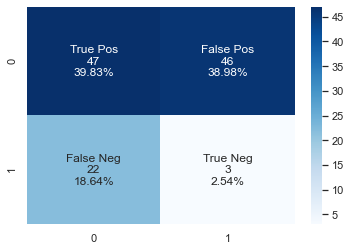

Scores for fold 7:
loss of 75.90767569461111
accuracy of 0.4237288236618042
precision of 0.6703097820281982
recall of 0.7661373019218445
auc of 0.845848798751831
true_positives of 12145.0
true_negatives of 53543.75
false_positives of 5973.5
------------------------------------------------------------------------

Training for fold 8 ...
Train on 799 samples, validate on 267 samples
Epoch 1/10
799/799 [==============================] - 11s 14ms/step - loss: 0.6912 - accuracy: 0.8260 - precision: 0.6686 - recall: 0.7664 - auc: 0.8459 - true_positives: 12217.1797 - true_negatives: 53820.7188 - false_positives: 6055.3198 - false_negatives: 3724.7600 - val_loss: 161.5161 - val_accuracy: 0.7790 - val_precision: 0.6680 - val_recall: 0.7657 - val_auc: 0.8456 - val_true_positives: 12295.7646 - val_true_negatives: 54185.1758 - val_false_positives: 6110.0586 - val_false_negatives: 3761.7058
Epoch 2/10
799/799 [==============================] - 8s 10ms/step - loss: 0.2091 - accuracy: 0.9437 - prec

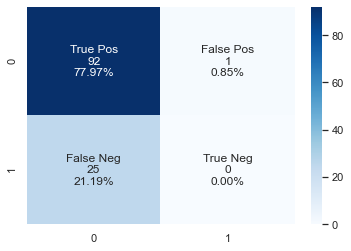

Scores for fold 8:
loss of 157.72814320709745
accuracy of 0.7881355881690979
precision of 0.6815584897994995
recall of 0.7638632655143738
auc of 0.8473732471466064
true_positives of 13837.0
true_negatives of 61568.0
false_positives of 6465.0
------------------------------------------------------------------------

Training for fold 9 ...
Train on 799 samples, validate on 267 samples
Epoch 1/10
799/799 [==============================] - 11s 14ms/step - loss: 0.9344 - accuracy: 0.8248 - precision: 0.6801 - recall: 0.7636 - auc: 0.8473 - true_positives: 13900.5195 - true_negatives: 61853.5781 - false_positives: 6537.5801 - false_negatives: 4304.2998 - val_loss: 89.0001 - val_accuracy: 0.6142 - val_precision: 0.6792 - val_recall: 0.7630 - val_auc: 0.8469 - val_true_positives: 13980.2354 - val_true_negatives: 62205.9414 - val_false_positives: 6602.9414 - val_false_negatives: 4341.5884
Epoch 2/10
799/799 [==============================] - 8s 10ms/step - loss: 0.2002 - accuracy: 0.9387 - prec

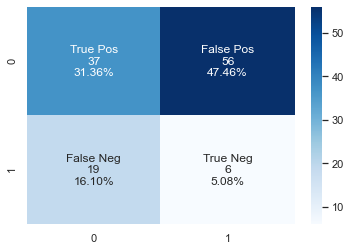

Scores for fold 9:
loss of 74.70443822569766
accuracy of 0.3644067943096161
precision of 0.6791930198669434
recall of 0.761141300201416
auc of 0.8455050587654114
true_positives of 15512.25
true_negatives of 69218.25
false_positives of 7327.0
------------------------------------------------------------------------

Training for fold 10 ...
Train on 799 samples, validate on 267 samples
Epoch 1/10
799/799 [==============================] - 10s 13ms/step - loss: 0.5741 - accuracy: 0.8798 - precision: 0.6786 - recall: 0.7614 - auc: 0.8457 - true_positives: 15593.2598 - true_negatives: 69508.0391 - false_positives: 7385.7402 - false_negatives: 4886.9399 - val_loss: 126.3588 - val_accuracy: 0.7640 - val_precision: 0.6784 - val_recall: 0.7607 - val_auc: 0.8454 - val_true_positives: 15661.0000 - val_true_negatives: 69896.5312 - val_false_positives: 7423.8823 - val_false_negatives: 4927.2939
Epoch 2/10
799/799 [==============================] - 9s 11ms/step - loss: 0.3492 - accuracy: 0.9262 - pr

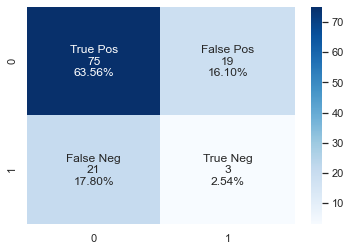

Scores for fold 10:
loss of 83.78024893291926
accuracy of 0.6610169410705566
precision of 0.6798443794250488
recall of 0.7618228197097778
auc of 0.8460912704467773
true_positives of 17257.0
true_negatives of 76924.5
false_positives of 8126.75


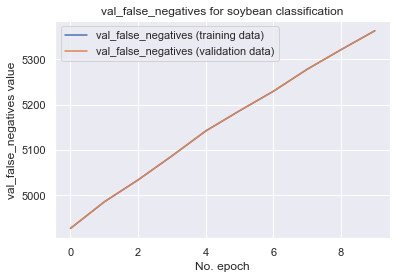

In [19]:
EPOCHS = 10
TRAIN_TEST_SPLIT = 0.25
BATCH_SIZE = 16
acc, prec, rec, auc = train_models(images, labels)

In [20]:
print("Acurácia média: ",np.mean(acc))
print("Precisão média: ",np.mean(prec))
print("Recall médio: ",np.mean(rec))
print("Auc média: ",np.mean(auc))

Acurácia média:  0.5458268120884895
Precisão média:  0.6899897873401641
Recall médio:  0.761276924610138
Auc média:  0.847525680065155


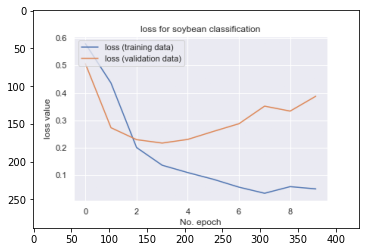

FileNotFoundError: [Errno 2] No such file or directory: '../metricas/classificacao/7_d/tests-binary/adhoc/models\\model_2\\loss.png'

In [2]:
import os
import matplotlib.pyplot as plt
for model in os.listdir("../metricas/classificacao/7_d/tests-binary/adhoc/models"):
    metric_path = os.path.join("../metricas/classificacao/7_d/tests-binary/adhoc/models", model, "loss.png")
    img = plt.imread(metric_path)
    plt.imshow(img)
    plt.show()